# Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

## Reading and Understanding data

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

In [89]:
#read the data
housing = pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [90]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [91]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


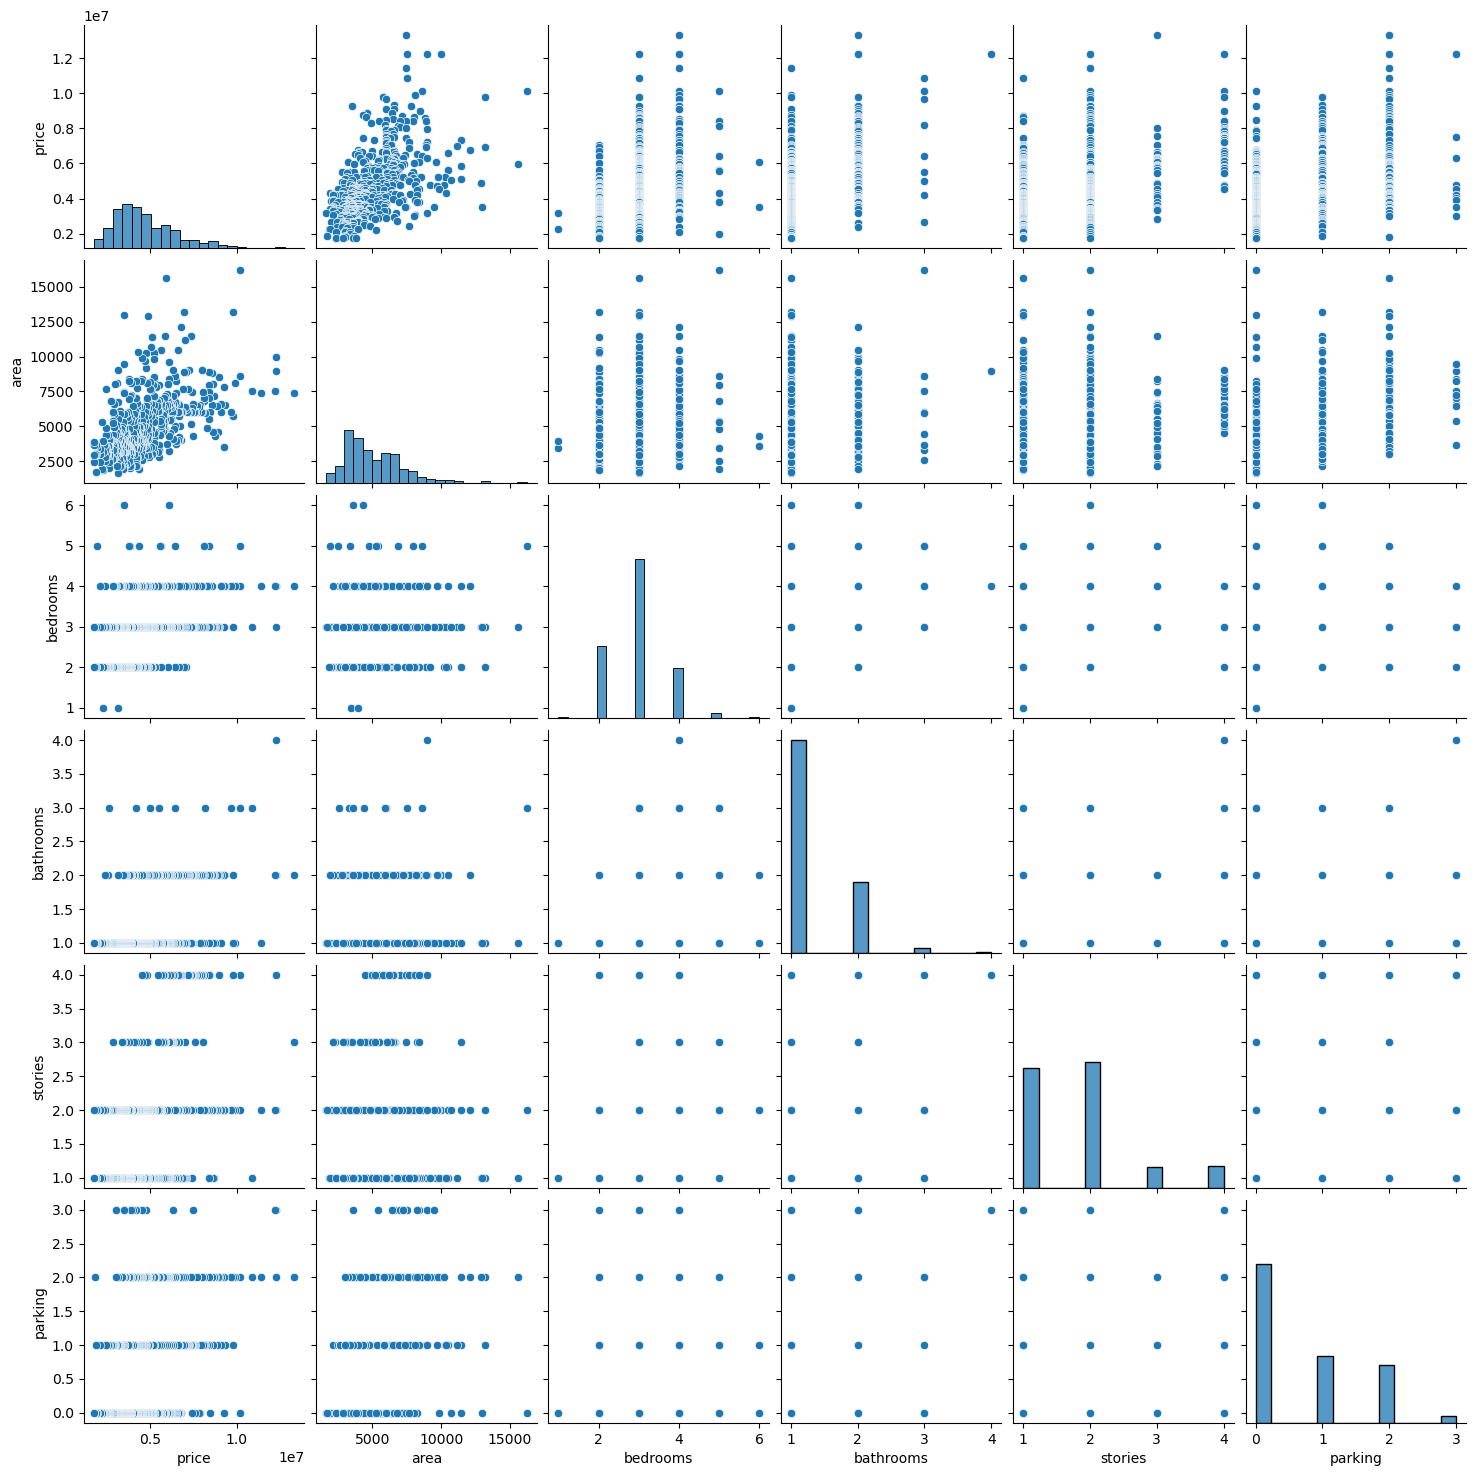

In [92]:
#visualize the data (Numeric Variables)
sns.pairplot(housing)
plt.show()

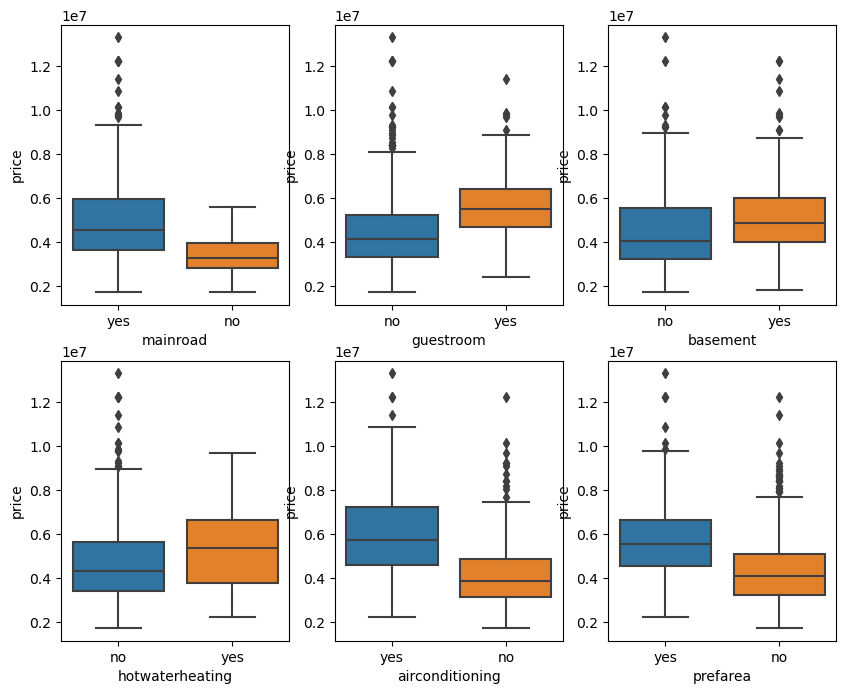

In [93]:
#visualize the data (Categorical Variables) 
plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
sns.boxplot(x='mainroad',y='price',data=housing)
plt.subplot(2,3,2)
sns.boxplot(x='guestroom',y='price',data=housing)
plt.subplot(2,3,3)
sns.boxplot(x='basement',y='price',data=housing)
plt.subplot(2,3,4)
sns.boxplot(x='hotwaterheating',y='price',data=housing)
plt.subplot(2,3,5)
sns.boxplot(x='airconditioning',y='price',data=housing)
plt.subplot(2,3,6)
sns.boxplot(x='prefarea',y='price',data=housing)
plt.show()

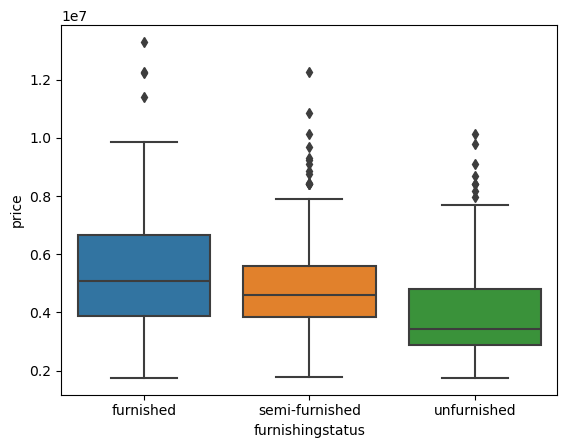

In [94]:
sns.boxplot(x='furnishingstatus',y='price',data=housing)
plt.show()

## Data Preparation for Modelling

In [95]:
#Identifying binary vars

varlist = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
housing[varlist].head()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,yes,no,no,no,yes,yes
1,yes,no,no,no,yes,no
2,yes,no,yes,no,no,yes
3,yes,no,yes,no,yes,yes
4,yes,yes,yes,no,yes,no


In [96]:
#Converting binary vars to 1/0

housing[varlist] = housing[varlist].apply(lambda x: x.map({'yes':1,'no':0}))
housing[varlist].head()

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1,0,0,0,1,1
1,1,0,0,0,1,0
2,1,0,1,0,0,1
3,1,0,1,0,1,1
4,1,1,1,0,1,0


In [97]:
#create dummy variables

status = pd.get_dummies(housing['furnishingstatus'], dtype=int)
status.head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [98]:
#dropping a redudant dummy var

status = pd.get_dummies(housing['furnishingstatus'], dtype=int, drop_first=True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


##### 00 - furnished
##### 01 - unfurnished
##### 10 - semi-furnished

In [99]:
#concat the dummp dataframe with the original one

housing = pd.concat([housing,status],axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [100]:
housing = housing.drop('furnishingstatus',axis =1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [101]:
#Split train and test data

df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)
df_train.shape

(381, 14)

In [102]:
df_test.shape

(164, 14)

In [103]:
scaler = MinMaxScaler()

In [104]:
#create list of numeric vars
num_vars = ['area','bathrooms','stories','parking','price']

In [105]:
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train[num_vars].head()

,area,bathrooms,stories,parking,price
359,0.155227,0.0,0.000000,0.333333,0.169697
19,0.403379,0.5,0.333333,0.333333,0.615152
159,0.115628,0.5,0.000000,0.000000,0.321212
35,0.454417,0.5,1.000000,0.666667,0.548133
28,0.538015,0.5,0.333333,0.666667,0.575758


## Training the Model

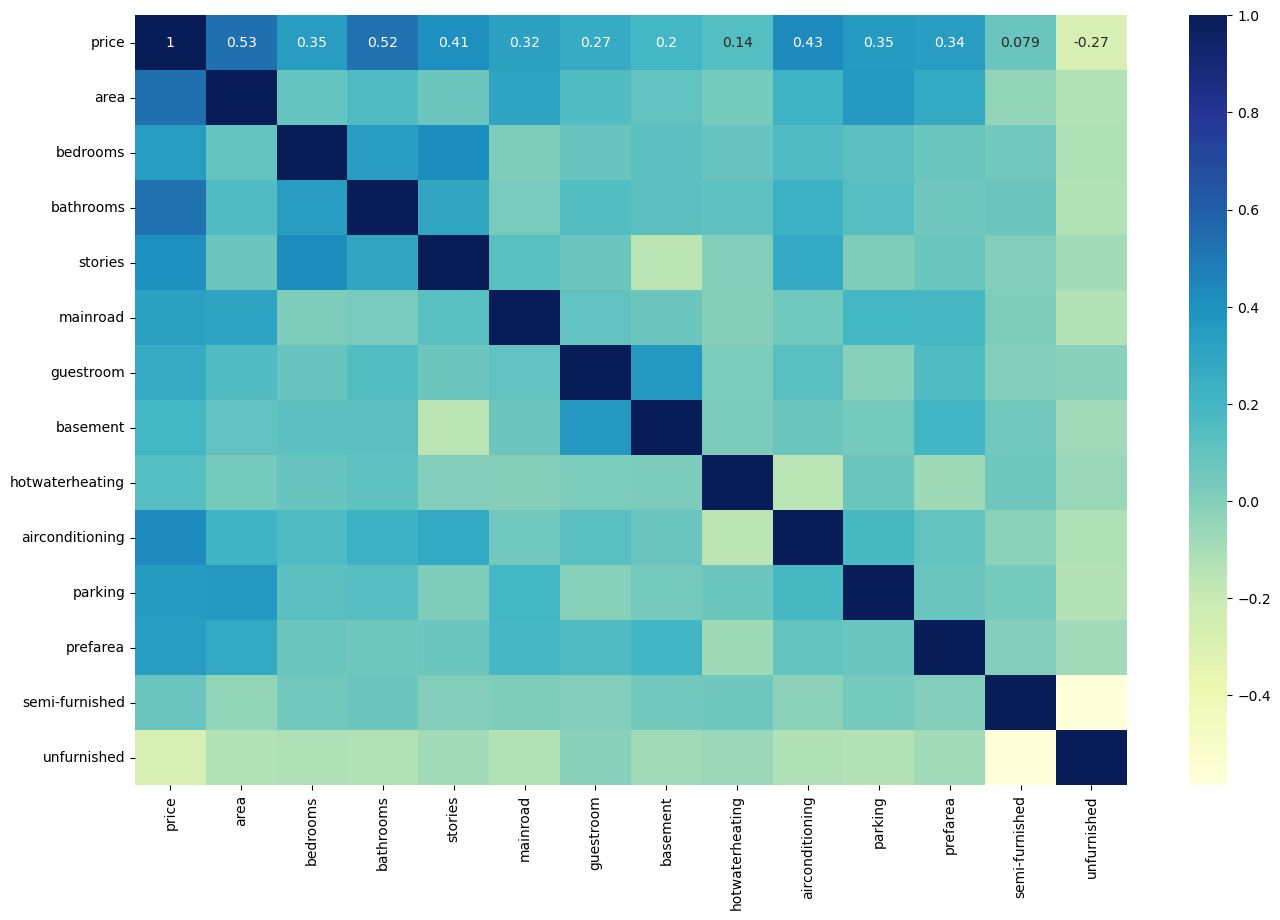

In [106]:
#plotting correlation with all the variales

plt.figure(figsize=(16,10))
sns.heatmap(df_train.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [107]:
y_train = df_train.pop('price')
X_train = df_train

In [108]:
#add a constant

X_train_sm = sm.add_constant(X_train['area'])
X_train_sm.head()

,const,area
359,1.0,0.155227
19,1.0,0.403379
159,1.0,0.115628
35,1.0,0.454417
28,1.0,0.538015


In [109]:
lr = sm.OLS(y_train,X_train_sm)

In [110]:
lr_model = lr.fit()

In [111]:
lr_model.params

const    0.126894
area     0.462192
dtype: float64

In [112]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           3.15e-29
Time:                        19:23:27   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.000       0.102       0.152
area           0.4622      0.038     12.232      0.000       0.388       0.536
==============================================================================
Omnibus:                       67.313   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.063
Skew:                           0.925   Prob(JB):                     8.59e-32
Kurtosis:                       5.365   Cond. No.                         5.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [113]:
#add another variable

X_train_sm = X_train[['area','bathrooms']]
X_train_sm = sm.add_constant(X_train_sm)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.params

const        0.104589
area         0.398396
bathrooms    0.298374
dtype: float64

In [114]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           2.51e-54
Time:                        19:23:29   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.000       0.083       0.127
area           0.3984      0.033     12.192      0.000       0.334       0.463
bathrooms      0.2984      0.025     11.945      0.000       0.249       0.347
==============================================================================
Omnibus:                       62.839   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.790
Skew:                           0.784   Prob(JB):                     2.23e-37
Kurtosis:                       5.859   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
#add another variable

X_train_sm = X_train[['area','bathrooms','bedrooms']]
X_train_sm = sm.add_constant(X_train_sm)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.params

const        0.004980
area         0.392211
bathrooms    0.259978
bedrooms     0.036373
dtype: float64

In [116]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           3.12e-57
Time:                        19:23:32   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.025      0.198      0.843      -0.044       0.054
area           0.3922      0.032     12.279      0.000       0.329       0.455
bathrooms      0.2600      0.026     10.033      0.000       0.209       0.311
bedrooms       0.0364      0.008      4.396      0.000       0.020       0.053
==============================================================================
Omnibus:                       50.037   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.806
Skew:                           0.648   Prob(JB):                     7.92e-28
Kurtosis:                       5.487   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
#adding all the variables to the model

X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           8.83e-83
Time:                        19:23:32   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0107      0.026      0.413      0.680      -0.040       0.062
area                0.2347      0.030      7.795      0.000       0.175       0.294
bedrooms            0.0093      0.007      1.267      0.206      -0.005       0.024
bathrooms           0.1908      0.022      8.679      0.000       0.148       0.234
stories             0.1085      0.019      5.661      0.000       0.071       0.146
mainroad            0.0504      0.014      3.520      0.000       0.022       0.079
guestroom           0.0304      0.014      2.233      0.026       0.004       0.057
basement            0.0216      0.011      1.943      0.053      -0.000       0.043
hotwaterheating     0.0849      0.022      3.934      0.000       0.042       0.127
airconditioning     0.0669      0.011      5.899      0.000       0.045       0.089
parking             0.0607      0.018      3.365      0.001       0.025       0.096
prefarea            0.0594      0.012      5.040      0.000       0.036       0.083
semi-furnished      0.0009      0.012      0.078      0.938      -0.022       0.024
unfurnished        -0.0310      0.013     -2.440      0.015      -0.056      -0.006
==============================================================================
Omnibus:                       93.687   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.917
Skew:                           1.091   Prob(JB):                     6.14e-67
Kurtosis:                       6.801   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
#crate df for VIF

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
1,bedrooms,10.30
4,mainroad,6.58
0,area,4.75
3,stories,2.64
11,semi-furnished,2.36
9,parking,2.12
6,basement,2.02
12,unfurnished,2.01
8,airconditioning,1.78
2,bathrooms,1.65


In [119]:
#dropping semi-furnished

X=X_train.drop('semi-furnished',axis=1)

In [120]:
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           1.07e-83
Time:                        19:23:34   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0114      0.024      0.471      0.638      -0.036       0.059
area                0.2344      0.030      7.845      0.000       0.176       0.293
bedrooms            0.0093      0.007      1.268      0.206      -0.005       0.024
bathrooms           0.1909      0.022      8.697      0.000       0.148       0.234
stories             0.1085      0.019      5.669      0.000       0.071       0.146
mainroad            0.0504      0.014      3.524      0.000       0.022       0.079
guestroom           0.0304      0.014      2.238      0.026       0.004       0.057
basement            0.0216      0.011      1.946      0.052      -0.000       0.043
hotwaterheating     0.0849      0.022      3.941      0.000       0.043       0.127
airconditioning     0.0668      0.011      5.923      0.000       0.045       0.089
parking             0.0608      0.018      3.372      0.001       0.025       0.096
prefarea            0.0594      0.012      5.046      0.000       0.036       0.083
unfurnished        -0.0316      0.010     -3.096      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       93.538   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.844
Skew:                           1.090   Prob(JB):                     1.05e-66
Kurtosis:                       6.794   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
#crate df for VIF

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
1,bedrooms,8.59
4,mainroad,6.45
0,area,4.74
3,stories,2.61
9,parking,2.12
6,basement,2.02
8,airconditioning,1.77
2,bathrooms,1.65
10,prefarea,1.51
5,guestroom,1.47


In [122]:
X=X.drop('bedrooms',axis=1)

In [123]:
X_train_sm = sm.add_constant(X)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           2.73e-84
Time:                        19:23:39   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015      2.421      0.016       0.007       0.065
area                0.2347      0.030      7.851      0.000       0.176       0.294
bathrooms           0.1965      0.022      9.132      0.000       0.154       0.239
stories             0.1178      0.018      6.654      0.000       0.083       0.153
mainroad            0.0488      0.014      3.423      0.001       0.021       0.077
guestroom           0.0301      0.014      2.211      0.028       0.003       0.057
basement            0.0239      0.011      2.183      0.030       0.002       0.045
hotwaterheating     0.0864      0.022      4.014      0.000       0.044       0.129
airconditioning     0.0665      0.011      5.895      0.000       0.044       0.089
parking             0.0629      0.018      3.501      0.001       0.028       0.098
prefarea            0.0596      0.012      5.061      0.000       0.036       0.083
unfurnished        -0.0323      0.010     -3.169      0.002      -0.052      -0.012
==============================================================================
Omnibus:                       97.661   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.388
Skew:                           1.130   Prob(JB):                     2.20e-71
Kurtosis:                       6.923   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
#crate df for VIF

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


## Final model ready

# Residual Analysis

<Axes: ylabel='Density'>

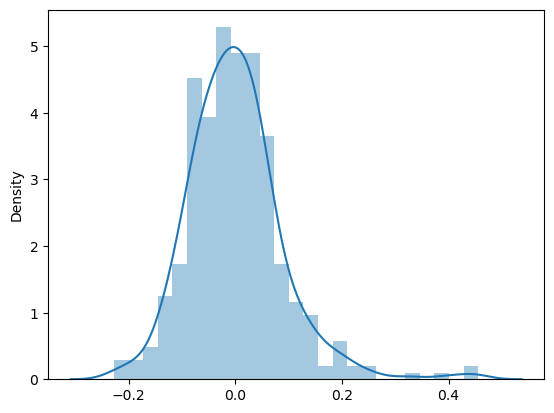

In [125]:
y_train_pred = lr_model.predict(X_train_sm)
res = y_train - y_train_pred
sns.distplot(res)

In [127]:
num_vars = ['area','bathrooms','stories','parking','price']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test[num_vars].head()

,area,bathrooms,stories,parking,price
265,0.091869,0.0,0.333333,0.000000,0.229697
54,0.366420,0.5,0.333333,0.333333,0.484848
171,0.742080,0.0,0.000000,0.333333,0.303030
244,0.306582,0.0,0.333333,0.000000,0.242424
268,0.274023,0.0,0.333333,0.000000,0.227879


In [128]:
df_test.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,3.042683,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.737685,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,3.000000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,3.000000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,5.000000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
y_test = df_test.pop('price')
X_test = df_test

In [130]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,1.0,0.091869,3,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,1.0,0.366420,3,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,1.0,0.742080,3,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,1.0,0.306582,3,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,1.0,0.274023,4,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


In [131]:
X_test_sm = X_test_sm.drop(['bedrooms','semi-furnished'],axis=1)
X_test_sm.head()

,const,area,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,unfurnished
265,1.0,0.091869,0.0,0.333333,1,0,0,0,0,0.000000,1,0
54,1.0,0.366420,0.5,0.333333,1,1,0,0,1,0.333333,0,0
171,1.0,0.742080,0.0,0.000000,1,0,0,0,0,0.333333,1,0
244,1.0,0.306582,0.0,0.333333,1,1,1,0,0,0.000000,1,0
268,1.0,0.274023,0.0,0.333333,1,0,0,0,1,0.000000,0,0


In [132]:
y_test_pred = lr_model.predict(X_test_sm)
y_test_pred.head()

265    0.204980
54     0.425613
171    0.339321
244    0.309397
268    0.254629
dtype: float64

In [133]:
r2_score(y_true=y_test,y_pred=y_test_pred)

0.6713505684480789

Text(0, 0.5, 'y_pred')

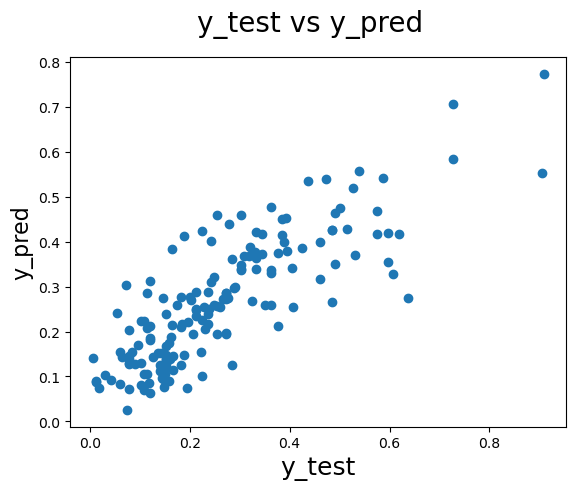

In [159]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      


We can see that the equation of our best fitted line is:

$ price = 0.236  \times  area + 0.202  \times  bathrooms + 0.11 \times stories + 0.05 \times mainroad + 0.04 \times guestroom + 0.0876 \times hotwaterheating + 0.0682 \times airconditioning + 0.0629 \times parking + 0.0637 \times prefarea - 0.0337 \times unfurnished $


Overall we have a decent model, but we also acknowledge that we could do better. 

We have a couple of options:
1. Add new features (bathrooms/bedrooms, area/stories, etc.)
2. Build a non-linear model